# day 233,day 235

# Goals:

1. download all 101 food classes
2. create a preprocessing function for our data.
3. batching the datasets(to make it run faster).
4. set up mixed precision training.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from pathlib import Path
import requests
import os
import zipfile
import tensorflow_datasets as tfds

In [ ]:
# checking the GPU type

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-116c143b-9e0a-6a18-68f7-2824dcfb2e68)


# note: for divergence in approach when preprocessing and batchifying.
* since we directly download it, we may have to take different approaches when preprocessing and batchfying the data. remember we had the directory before now we don't have the directory but image files from tensorflow datasets and tfds doesn't create a file/directory to store in all the images like we did before i suppose.


In [ ]:
# downloading the helper functions

if Path('helper_functions.py').is_file():
  print('Already Downloaded')
else:
  print('Downloading helper functions')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py').content
  with open('helper_functions.py','wb') as f:
    f.write(request)


Already Downloaded


In [ ]:
# import tensorflow_datasets and check whether food101 datasets is found within.
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders()

print('food101' in datasets_list)

True


# why use tensorflow_datasets

* tensorflow_datasets has a huge variety of problems to hone our expertise on a wide variety of datasets with unique challenges.
* these are good for practice.

# why not use tensorflow_datasets:

* because the real world is more dynammic and ever changing, having a model that is 100% working on model datasets does not guarantee that it will hold true when dealing with real world data, there will always be this inevitable error(the standard deviation) between actuallity and model.


In [ ]:
# importing the food101 datasets from tfds.load

(train_data,test_data),meta_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteLXWCFY/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteLXWCFY/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# exploration,analysis and freethrows

In [ ]:
meta_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# get the class names
class_names = meta_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# goal

* see input shape
* see data type
* see how the labels look, if the labels are one-hot encoded or in integers form.
* see whether you can use the labels to access the corresponding class names.
* see the values in the image tensor.
* see the minimum value and maximum value of the tensor to know what to normalize with later.
* visualize the image with the label.

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# take one sample from the train data and view it.
one_sample = train_data.take(1)

one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# print out the input shape, dtype, label, and corresponding class name of the label:
for image,label in one_sample:
  print('input shape: {}'.format(image.shape))
  print('dtype of the image: {}'.format(image.dtype))
  print('label: {}'.format(label))
  print('class name: {}'.format(class_names[label.numpy()]))

input shape: (512, 512, 3)
dtype of the image: <dtype: 'uint8'>
label: 49
class name: grilled_cheese_sandwich


In [ ]:
# seeing the values of image
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[239, 217, 157],
        [244, 222, 162],
        [247, 227, 168],
        ...,
        [119, 104,  73],
        [111,  95,  70],
        [105,  89,  66]],

       [[233, 212, 149],
        [239, 218, 155],
        [243, 223, 162],
        ...,
        [117, 102,  71],
        [108,  92,  67],
        [101,  85,  62]],

       [[227, 206, 139],
        [234, 213, 146],
        [238, 219, 153],
        ...,
        [117, 100,  70],
        [108,  91,  65],
        [101,  83,  59]],

       ...,

       [[ 35,   7,  19],
        [ 35,   7,  19],
        [ 36,   8,  20],
        ...,
        [198, 181, 127],
        [196, 179, 125],
        [193, 176, 122]],

       [[ 34,   6,  18],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [200, 183, 129],
        [201, 184, 130],
        [198, 181, 127]],

       [[ 33,   5,  17],
        [ 34,   6,  18],
        [ 35,   7,  19],
        ...,
        [203, 186, 13

In [ ]:
# analysing the minimum and maximum values of image.
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

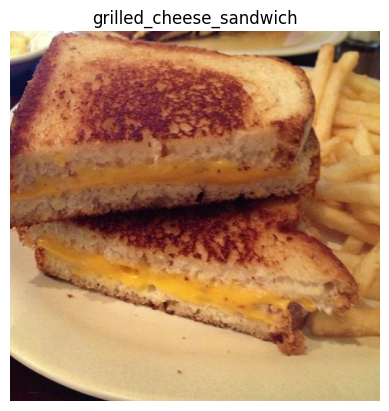

In [ ]:
# visualizing the image.
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis('off')
plt.show()

# goal

* preprocess the images with right image size(remember neural networks need all image sizes to be the same).
1. resize the images to 224,224
2. cast the image datatype to tf.float32(right now it is uint64).
3. we don't have it scale it or normalize the image if we were to use the efficient net models(because they have the inbuilt scaling feature).

# preprocess the images with the right image size

* preprocess function takes in both image and label because the train_data is built to give out both so if preprocess function would only have image then that might cause error.

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
def preprocess(image,label,image_size=[224,244]):
  # resize the image
  image = tf.image.resize(image,image_size)

  # cast to tf.float32
  image = tf.cast(image,tf.float32)

  return image,label

In [ ]:
preprocess(image,label)[0].shape

TensorShape([224, 244, 3])

In [ ]:
preprocess(image,label)[0].dtype

tf.float32

In [ ]:
# batchify the data:

'''
1. map the data to preprocess function.
2. utilize parallel calls.(more computing units parallely)
3. shuffle only the train data not test data at each iteration by some length.
4. prefetch the data. prefetching ensures that when one batch is being processed another is pulled from disk and
kept ready for processing.
5. AUTOTUNE the buffer sizes'''
# prepare the train data

# map the preprocess function on every individual images and labels of train_data
train_data = train_data.map(map_func=preprocess,num_parallel_calls=tf.data.AUTOTUNE)

# shuffle the train data by a length of 1000
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


# prepare the test data
test_data = test_data.map(map_func=preprocess,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# creating useful callbacks:

## 1. Tensorboard callbacks: -for keep a record of model's performance and visualize them later if need be.
----------
## 2. ModelCheckpoint callback: - for saving the model's performance at every epoch so that even if something like power cut happens during trianing we can refer to its last saved checkpoint.
-----------
## 3. Early stopping callback: - if the training time is humangously long, then we can stop the training midway when the loss or accuracy doesn't seem to improve much with this callback.

In [ ]:
# creating tensorboard callback
path_for_tensorboard = 'TensorBoard'

TensorBoard_callback = tf.keras.callbacks.TensorBoard(log_dir=path_for_tensorboard)

# creating model checkpoints:
path_for_checkpoints = 'Checkpoint'

ModelCheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_for_checkpoints,
                                                              monitor='val_acc',
                                                              save_best_only=True,
                                                              save_weights_only=True,
                                                              save_freq='epoch')



# recreate the above code here:

# day 236

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import requests,zipfile,os

In [2]:
# downloading the data

(train_data,test_data),meta_info = tfds.load(name='food101',
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             download=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete4MJ16H/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete4MJ16H/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


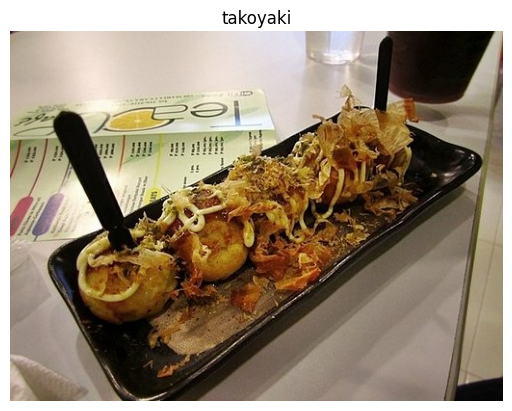

In [4]:
# # taking a sample image and visualizing it.

# getting class_names
class_names = meta_info.features['label'].names

# taking a sample image and visualizing it.
one_sample = train_data.take(1)

for image,label in one_sample:
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis('off')
  plt.show()

In [5]:
# analyzing the nature of the data
print('image shape: {}'.format(image.shape))
print('data type: {}'.format(image.dtype))

# printing the max and min values of image (to normalize it later based on this info)
print('max value in image: {}'.format(tf.reduce_max(image)))
print('min value in image: {}'.format(tf.reduce_min(image)))


image shape: (384, 512, 3)
data type: <dtype: 'uint8'>
max value in image: 255
min value in image: 0


In [12]:
# preprocessing the image

# to have standard image size and datatype
'''take in and return both image and label so that you do not run into conflicts while mapping '''
def preprocess(image,label,image_size=[224,224]): # pass both image and label here

  # resize the image
  image = tf.image.resize(image,image_size)

  # cast the image to float32
  image = tf.cast(image,tf.float32)

  return image,label





In [8]:
# do the following work
''' 1. map the preprocess function to train_data and test_data
    2. utilise parallel calls(simultaneous use of more computing resources to get the job done)
    3. AUTOTUNE the buffersizes
    4. shuffle the train data but not the test data
    5. determine the batch size in multiples of 8(since tensor cores are good with 8's)
    6. prefetch the to be processed data from disk while the current process is going on
'''

# preparing the training data
train_data = train_data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# preparing the testing data
test_data = test_data.map(preprocess,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# testing how the transformation has come upon train_data
train_data.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [31]:
# creating model checkpoints

def TensorBoard_callback(experiment_name):
  tensorboard_path = 'TensorBoardLogs' + '/' + experiment_name

  callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)

  return callback

def ModelCheckpoint_callback(experiment_name):
  ModelCheckpoint_path = 'ModelCheckpoints' + '/' + experiment_name

  callback = tf.keras.callbacks.ModelCheckpoint(filepath=ModelCheckpoint_path,
                                                monitor='val_acc',
                                                save_weights_only=True,
                                                save_freq='epoch',
                                                save_best_only=True)

  return callback

# setting mixed_precision:

* mixed precision speeds up the code's execution time.
* higher the accuracy, slower the computation speed. so we want to lower our floating accuracy to float16.
* but it may impact our numerical stability, in other words it may hurt our model's prediction especially with loss and accuracy metrics should they fall too low, so we want to use not only float 16 but float 32.
* float16 for speed. float32 for accuracy.
* float16 for computation. float32 for storage of variables.

In [14]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# creating our feature extractor model

In [28]:
# build the base model with all the layers frozen for training
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create the input layer
input_layer = tf.keras.Input(shape=[224,224,3])

# put the input layer into base model
x = base_model(input_layer,training=False)

# put the above layer inside GlobalAveragePooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)

# put the above layer inside the output layer(make sure to put it in tf.float32 for numerical stability)
output_layer = tf.keras.layers.Dense(units=len(class_names),activation='softmax',dtype=tf.float32,name='output_layer')(x)

# create the model
model0 = tf.keras.Model(input_layer,output_layer)

# compile the model
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

# fit the model
tf.random.set_seed(42)
feature_extractor_epochs = 3

history0 = model0.fit(train_data,
                      epochs=feature_extractor_epochs,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[TensorBoard_callback('model0_efficientnetv2b0'),ModelCheckpoint_callback])


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7478 - accuracy: 0.5775

2368/2368 [==============================] - 213s 82ms/step - loss: 1.7478 - accuracy: 0.5775 - val_loss: 1.1461 - val_accuracy: 0.6957
Epoch 2/3
2366/2368 [============================>.] - ETA: 0s - loss: 1.2112 - accuracy: 0.6858

2368/2368 [==============================] - 183s 76ms/step - loss: 1.2112 - accuracy: 0.6858 - val_loss: 1.0473 - val_accuracy: 0.7203
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0628 - accuracy: 0.7231

2368/2368 [==============================] - 176s 73ms/step - loss: 1.0628 - accuracy: 0.7231 - val_loss: 0.9935 - val_accuracy: 0.7296


# fine-tuning our model

In [33]:
# unfreeze some layers at the end
base_model.trainable = True
for layer in base_model.layers[:-8]:
  layer.trainable = False

# recompile the model but this time with 10x lower learning_rate
model0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

# fit the model
tf.random.set_seed(42)
history1 = model0.fit(train_data,
                      epochs=feature_extractor_epochs+5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      initial_epoch=4, # start from 4th epoch
                      callbacks=[TensorBoard_callback('model1_efficientnetv2b0'),
                                 ModelCheckpoint_callback('model1_efficientnetv2b0')])

Epoch 5/8
2368/2368 [==============================] - ETA: 0s - loss: 0.8794 - accuracy: 0.7658

2368/2368 [==============================] - 207s 81ms/step - loss: 0.8794 - accuracy: 0.7658 - val_loss: 0.8843 - val_accuracy: 0.7606
Epoch 6/8
2366/2368 [============================>.] - ETA: 0s - loss: 0.7832 - accuracy: 0.7920

2368/2368 [==============================] - 186s 78ms/step - loss: 0.7832 - accuracy: 0.7920 - val_loss: 0.8696 - val_accuracy: 0.7614
Epoch 7/8
2366/2368 [============================>.] - ETA: 0s - loss: 0.7139 - accuracy: 0.8114

2368/2368 [==============================] - 183s 76ms/step - loss: 0.7140 - accuracy: 0.8114 - val_loss: 0.8589 - val_accuracy: 0.7704
Epoch 8/8
2366/2368 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.8265

2368/2368 [==============================] - 186s 77ms/step - loss: 0.6569 - accuracy: 0.8265 - val_loss: 0.8502 - val_accuracy: 0.7725


In [35]:
model0.evaluate(test_data)

790/790 [==============================] - 58s 73ms/step - loss: 0.8558 - accuracy: 0.7626


[0.8557582497596741, 0.762613832950592]

# exploration,analysis and freethrows

In [16]:
# seeing the model summary(especially how the output layer looks)
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 GlobalAveragePooling (Glob  (None, 1280)              0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 6048693 (23.07 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [21]:
# checking how the layers look after mixed precision.
for layer in model0.layers:
  print('dtype policy of the layer: {}'.format(layer.dtype_policy))
  print('dtype of the layer: {}'.format(layer.dtype))

# we use float32 for storage  and float16 for computation.

dtype policy of the layer: <Policy "float32">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "float32">
dtype of the layer: float32


In [24]:
# checking how the layers look after mixed precision in base_model.
for layer in base_model.layers:
  print('dtype policy of the layer: {}'.format(layer.dtype_policy))
  print('dtype of the layer: {}'.format(layer.dtype))



dtype policy of the layer: <Policy "float32">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_float16">
dtype of the layer: float32
dtype policy of the layer: <Policy "mixed_floa